In [1]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
%matplotlib notebook

Reads in the drone data file and converts it into a dataframe

In [2]:
def read_drone(infile):
    """Takes in the csv file from the drone flight path, gets
    rid of columns I won't use"""
    drone_data = pd.read_csv(infile)
    dataframe = drone_data[['time(millisecond)',
                            'datetime(utc)',
                            'latitude',
                            'longitude',
                            'height_above_takeoff(feet)']].copy()
    dataframe.rename(
        columns={
            'time(millisecond)': 'milliseconds',
            'datetime(utc)': 'time'},
        inplace=True)
    new_time = list()
    confidence = list()
    for i in range(0, len(dataframe)):
        time = dt.strptime(dataframe['time'][i], "%Y-%m-%d %H:%M:%S")
        new_time.append(time)
         # radius of data area. Aperature is +- 20 degrees (0.349 rads)
        confidence.append(dataframe['height_above_takeoff(feet)'][i] * math.tan(0.349066))
    
    del dataframe['time']
    dataframe.insert(1, 'time', new_time)
    dataframe.insert(5, 'confidence', confidence)
    return dataframe

Reads in the STELLA data file

In [3]:
def read_stella(infile):
    """Takes in the data file from Stella as input, for every point Stella records,
    the information is saved into a Stella dictionary with the keys cooresponding to
    the apporpriate output from the file. Every point is then stored into a list and
    the final list of all the points is returned"""
    file = infile.readlines()
    all_stella_points = list()
    num = 0
    start = float
    for line in file:
        num += 1
        line = line.split(',')
        stella = {
        'point number': int,
        'batch': str,
        'day': str,
        'time stamp': str,
        'decimal hour': str,
        'surface temp units': str,
        'surface temp': float,
        'surface temp error bar': float,
        'air temp units': str,
        'air temp': float,
        'air temp error bar': float,
        'relative humidity units': str,
        'relative humidity': float,
        'relative humidity error bar': float,
        'air pressure units': str,
        'air pressure': float,
        'air pressure error bar': float,
        'altitude units': str,
        'altitude (uncalibrated)': float,
        'altitude error bar': float,
        'vis error bar': str,
        'nir error bar': str,
        'vis_pows': {
            '450': float,
            '500': float,
            '550': float,
            '570': float,
            '600': float,
            '650': float},
        'nir_pows': {
            '610': float,
            '680': float,
            '730': float,
            '760': float,
            '810': float,
            '860': float}}
        if len(line) != 57:
            print("Error in Format of file, please check again")
            return
        if num == 1:
            start = float(line[4]) 
        stella['point number'] = num
        stella['batch'] = line[0]
        stella['day'] = line[1]
        stella['time stamp'] = dt.strptime(line[2], "%Y%m%dT%H%M%SZ")
        ms = float(line[4]) - start
        stella['milliseconds'] = ms
        stella['decimal hour'] = line[4]
        stella['surface temp units'] = line[6]
        stella['surface temp'] = float(line[7])
        stella['surface temp error bar'] = float(line[8])
        stella['air temp units'] = line[10]
        stella['air temp'] = float(line[11])
        stella['air temp error bar'] = float(line[12])
        stella['relative humidity units'] = line[14]
        stella['relative humidity'] = float(line[15])
        stella['relative humidity error bar'] = float(line[16])
        stella['air pressure units'] = line[18]
        stella['air pressure'] = float(line[19])
        stella['air pressure error bar'] = float(line[20])
        stella['altitude units'] = line[22]
        stella['altitude (uncalibrated)'] = float(line[23])
        stella['altitude error bar'] = float(line[24])
        stella['vis error bar'] = line[29]
        stella['vis_pows'] = {'450': float(line[30]),
                              '500': float(line[32]),
                              '550': float(line[34]),
                              '570': float(line[36]),
                              '600': float(line[38]),
                              '650': float(line[40])}
        stella['nir error bar'] = line[45]
        stella['nir_pows'] = {'610': float(line[46]),
                              '680': float(line[48]),
                              '730': float(line[50]),
                              '760': float(line[52]),
                              '810': float(line[54]),
                              '860': float(line[56].strip('\n'))}
        all_stella_points.append(stella)
    return all_stella_points

Finds and get's the batch for a particular set of STELLA data based on the gps data input 

In [4]:
def detect_batch(gps_list, stella_list):
    batch = stella_list[0]['batch']
    time = gps_list['time'][0]
    prev_delta = abs((time - stella_list[0]['time stamp']).total_seconds())
    for s in stella_list:
        delta = abs((time - s['time stamp']).total_seconds())
        if delta < prev_delta:
            delta = prev_delta
            batch = s['batch']
    return batch


def get_batch(stella_list, batch):
    points = []
    for stella in stella_list:
        if stella['batch'] == batch:
            points.append(stella)
    return points

Removes a bunch of data from the begininning of the stella data because their is a significant amount of useless points at launch because we must turn STELLA on and then start the drone flight

In [5]:
def chop_takeoff(gps_list, stella_list):
    stella_time_delta = (stella_list[len(stella_list) - 1]['milliseconds'] - stella_list[0]['milliseconds']) / len(stella_list)
    gps_time_delta = (gps_list['milliseconds'][len(gps_list)- 1] - gps_list['milliseconds'][0]) / len(gps_list)
    milliseconds = list()
    ratio = stella_time_delta / gps_time_delta
    longer_flag = 's'
    num_extra = len(stella_list) - len(gps_list)/ratio

    if ratio < 1:
        ratio = 1 / ratio
        longer_flag = 'g'
        num_extra = len(gps_list) - len(stella_list)/ratio

    # only chop half of the extra.
    # assume other half are at the end and will be chopped by pairing
    shift = num_extra / 2.1
    if int(shift) > 0:
        if longer_flag  == 's':
            for i in range(int(shift), -1, -1):
                stella_list.pop(i)
            start = stella_list[0]['milliseconds']
            for s in stella_list:
                s['milliseconds'] -= start
        if longer_flag  == 'g':
            for i in range(int(shift), -1, -1):
                gps_list.drop(i)
            start = gps_list['milliseconds'][0]
            for i in range(0, len(gps_list)):
                milliseconds.append(gps_list['milliseconds'][i] - start)
            del gps_list['milliseconds']
            gps_list.insert(0, 'milliseconds', milliseconds)
    # print(len(stella_list))

Finds the minimum longitude in the GPS data and the Maximum latitude 

In [6]:
def find_min_lon(gps_list):
    num_points = len(gps_list)
    min_lat = gps_list['longitude'][0]
    for i in range(num_points):
        if gps_list['longitude'][i] < min_lat:
            min_lat = gps_list['longitude'][i]
    return min_lat

def find_min_lat(gps_list):
    num_points = len(gps_list)
    min_lat = gps_list['latitude'][0]
    for i in range(num_points):
        if gps_list['latitude'][i] < min_lat:
            min_lat = gps_list['latitude'][i]
    return min_lat

def find_max_lat(gps_list):
    num_points = len(gps_list)
    max_lat = gps_list['latitude'][0]
    for i in range(num_points):
        if gps_list['latitude'][i] > max_lat:
            max_lat = gps_list['latitude'][i]
    return max_lat

Makes maplist of the STELLA data points and their coorsponding gps points, maplist is a pandas dataframe (this function coorelates to the 1st gps flight path)

In [7]:
def set_xy1(gps_list, stella_list):
    min_lon = find_min_lon(gps_list)
    max_lat = find_max_lat(gps_list)

    map_list = []
    latitude = list()
    longitude = list()
    gps_milliseconds = list()
    gps_time = list()
    batch = list()
    day = list()
    stella_timestamp =  list()
    stella_decimalhour = list()
    surface_temp = list()
    air_temp = list()
    relative_humidity = list()
    air_pressure = list()
    altitude = list()
    vis_450 = list()
    vis_500 = list()
    vis_550 = list()
    vis_570 = list()
    vis_600 = list()
    vis_650 = list()
    nir_610 = list()
    nir_680 = list()
    nir_730 = list()
    nir_760 = list()
    nir_810 = list()
    nir_860 = list()
    x_coor = list()
    y_coor = list()
    confidence = list()
    chop_takeoff(gps_list, stella_list)
    s_cur = 0
    g_cur = 0
    for i in range(0, len(gps_list)):
        y = abs(max_lat - gps_list['latitude'][g_cur])
        x = (gps_list['longitude'][g_cur] - min_lon) 
        if s_cur < len(stella_list):
            if g_cur == 0:
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                post_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur + 1])
                if cur_delta < post_delta:
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1
            elif g_cur < len(gps_list):
                prev_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur - 1])
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                if cur_delta < prev_delta:
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1
            else:
                prev_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur - 1])
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                post_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur + 1])
                if cur_delta < prev_delta and cur_delta < post_delta:
                    print("found 3")
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1

        g_cur += 1
        # color = set_color(stella)                         # create RGB color (type str)
        # print(stella.timestamp, ', ', gps.time, ', ', gps.latitude, ', ',
        # gps.longitude, color)   # and associated color
    map_points = pd.DataFrame()
    map_points.insert(0, 'Latitude', latitude)
    map_points.insert(1, 'Longitude', longitude)
    map_points.insert(2, 'Milliseconds(gps)', gps_milliseconds)
    map_points.insert(3, 'Time(gps)', gps_time)
    map_points.insert(4, 'Batch', batch)
    map_points.insert(5, 'Day', day)
    map_points.insert(6, 'Time(stella)', stella_timestamp)
    map_points.insert(7, 'Decimal Hour', stella_decimalhour)
    map_points.insert(8, 'Surface Temp', surface_temp)
    map_points.insert(9, 'Air Temp', air_temp)
    map_points.insert(10, 'Rel Humidity', relative_humidity)
    map_points.insert(11, 'Air Pressure', air_pressure)
    map_points.insert(12, 'Altitude', altitude)
    map_points.insert(13, '450 nm', vis_450)
    map_points.insert(14, '500 nm', vis_500)
    map_points.insert(15, '550 nm', vis_550)
    map_points.insert(16, '570 nm', vis_570)
    map_points.insert(17, '600 nm', vis_600)
    map_points.insert(18, '650 nm', vis_650)
    map_points.insert(19, '610 nm', nir_610)
    map_points.insert(20, '680 nm', nir_680)
    map_points.insert(21, '730 nm', nir_730)
    map_points.insert(22, '760 nm', nir_760)
    map_points.insert(23, '810 nm', nir_810)
    map_points.insert(24, '860 nm', nir_860)
    map_points.insert(25, "X-Coordinate", x_coor)
    map_points.insert(26, "Y-Coordinate", y_coor)
    map_points.insert(27, 'Confidence', confidence)
    return map_points
 

Makes maplist of the STELLA data points and their coorsponding gps points, maplist is a pandas dataframe (this function coorelates to the 2nd gps flight path)

In [8]:
def set_xy2(gps_list, stella_list):
    min_lon = find_min_lon(gps_list)
    max_lat = find_max_lat(gps_list)

    map_list = []
    latitude = list()
    longitude = list()
    gps_milliseconds = list()
    gps_time = list()
    batch = list()
    day = list()
    stella_timestamp =  list()
    stella_decimalhour = list()
    surface_temp = list()
    air_temp = list()
    relative_humidity = list()
    air_pressure = list()
    altitude = list()
    vis_450 = list()
    vis_500 = list()
    vis_550 = list()
    vis_570 = list()
    vis_600 = list()
    vis_650 = list()
    nir_610 = list()
    nir_680 = list()
    nir_730 = list()
    nir_760 = list()
    nir_810 = list()
    nir_860 = list()
    x_coor = list()
    y_coor = list()
    confidence = list()
    chop_takeoff(gps_list, stella_list)
    s_cur = 0
    g_cur = 0
    for i in range(0, len(gps_list)):
        y = abs(max_lat - gps_list['latitude'][g_cur])
        x = (gps_list['longitude'][g_cur] - min_lon) 
        if s_cur < len(stella_list):
            if g_cur == 0:
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                post_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur + 1])
                if cur_delta < post_delta:
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1
            elif g_cur < len(gps_list):
                prev_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur - 1])
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                if cur_delta > prev_delta:
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1
            else:
                prev_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur - 1])
                cur_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur])
                post_delta = abs(stella_list[s_cur]['time stamp'] - gps_list['time'][g_cur + 1])
                if cur_delta < prev_delta and cur_delta < post_delta:
                    print("found 3")
                    latitude.append(gps_list['latitude'][g_cur])
                    longitude.append(gps_list['longitude'][g_cur])
                    gps_milliseconds.append(gps_list['milliseconds'][g_cur])
                    gps_time.append(gps_list['time'][g_cur])
                    batch.append(stella_list[s_cur]['batch'])
                    day.append(stella_list[s_cur]['day'])
                    stella_timestamp.append(stella_list[s_cur]['time stamp'])
                    stella_decimalhour.append(stella_list[s_cur]['decimal hour'])
                    surface_temp.append(stella_list[s_cur]['surface temp'])
                    air_temp.append(stella_list[s_cur]['air temp'])
                    relative_humidity.append(stella_list[s_cur]['relative humidity'])
                    air_pressure.append(stella_list[s_cur]['air pressure'])
                    altitude.append(stella_list[s_cur]['altitude (uncalibrated)'])
                    vis_450.append(stella_list[s_cur]['vis_pows']['450'])
                    vis_500.append(stella_list[s_cur]['vis_pows']['500'])
                    vis_550.append(stella_list[s_cur]['vis_pows']['550'])
                    vis_570.append(stella_list[s_cur]['vis_pows']['570'])
                    vis_600.append(stella_list[s_cur]['vis_pows']['600'])
                    vis_650.append(stella_list[s_cur]['vis_pows']['650'])
                    nir_610.append(stella_list[s_cur]['nir_pows']['610'])
                    nir_680.append(stella_list[s_cur]['nir_pows']['680'])
                    nir_730.append(stella_list[s_cur]['nir_pows']['730'])
                    nir_760.append(stella_list[s_cur]['nir_pows']['760'])
                    nir_810.append(stella_list[s_cur]['nir_pows']['810'])
                    nir_860.append(stella_list[s_cur]['nir_pows']['860'])
                    x_coor.append(x)
                    y_coor.append(y)
                    confidence.append(gps_list['confidence'][g_cur])
                    s_cur += 1

        g_cur += 1
        # color = set_color(stella)                         # create RGB color (type str)
        # print(stella.timestamp, ', ', gps.time, ', ', gps.latitude, ', ',
        # gps.longitude, color)   # and associated color
    map_points = pd.DataFrame()
    map_points.insert(0, 'Latitude', latitude)
    map_points.insert(1, 'Longitude', longitude)
    map_points.insert(2, 'Milliseconds(gps)', gps_milliseconds)
    map_points.insert(3, 'Time(gps)', gps_time)
    map_points.insert(4, 'Batch', batch)
    map_points.insert(5, 'Day', day)
    map_points.insert(6, 'Time(stella)', stella_timestamp)
    map_points.insert(7, 'Decimal Hour', stella_decimalhour)
    map_points.insert(8, 'Surface Temp', surface_temp)
    map_points.insert(9, 'Air Temp', air_temp)
    map_points.insert(10, 'Rel Humidity', relative_humidity)
    map_points.insert(11, 'Air Pressure', air_pressure)
    map_points.insert(12, 'Altitude', altitude)
    map_points.insert(13, '450 nm', vis_450)
    map_points.insert(14, '500 nm', vis_500)
    map_points.insert(15, '550 nm', vis_550)
    map_points.insert(16, '570 nm', vis_570)
    map_points.insert(17, '600 nm', vis_600)
    map_points.insert(18, '650 nm', vis_650)
    map_points.insert(19, '610 nm', nir_610)
    map_points.insert(20, '680 nm', nir_680)
    map_points.insert(21, '730 nm', nir_730)
    map_points.insert(22, '760 nm', nir_760)
    map_points.insert(23, '810 nm', nir_810)
    map_points.insert(24, '860 nm', nir_860)
    map_points.insert(25, "X-Coordinate", x_coor)
    map_points.insert(26, "Y-Coordinate", y_coor)
    map_points.insert(27, 'Confidence', confidence)
    return map_points
 

all read in files and making dataframes of accurate data

In [9]:
try:
    stella_infile = open("data.txt", 'r')
except FileNotFoundError:
    print("Error: Stella File not found")
    exit()
else:
    stella_data = read_stella(stella_infile)
    stella_infile.close()
try:
    drone_infile1 = open(
        "Data Files_Feb-26th-2021-05-57PM-Flight-Airdata.csv", 'r')
    drone_infile2 = open("Data Files_Apr-17th-2021-04-55PM-Flight-Airdata.csv", 'r')
except FileNotFoundError:
    print("Error: Drone File not found")
    exit()
else:
    gps_data1 = read_drone(drone_infile1)
    gps_data2 = read_drone(drone_infile2)
    stella_list1 = get_batch(stella_data, detect_batch(gps_data1, stella_data))
    stella_list2 = get_batch(stella_data, detect_batch(gps_data2, stella_data))
    maplist1 = set_xy1(gps_data1, stella_list1)
    maplist2 = set_xy2(gps_data2, stella_list2)
    #print(maplist1)
    #print(maplist2)


<IPython.core.display.Javascript object>


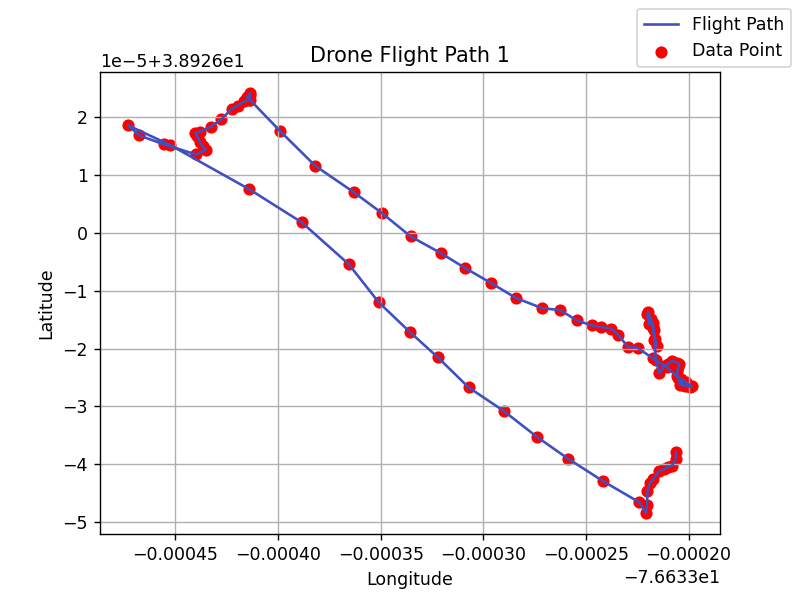

In [10]:
fig, ax = plt.subplots()
ax.scatter(maplist1['Longitude'], maplist1['Latitude'], c='red')
ax.plot(maplist1['Longitude'], maplist1['Latitude'], c='#3f50c0')
fig.legend(['Flight Path', 'Data Point'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Drone Flight Path 1")
plt.grid()


<IPython.core.display.Javascript object>


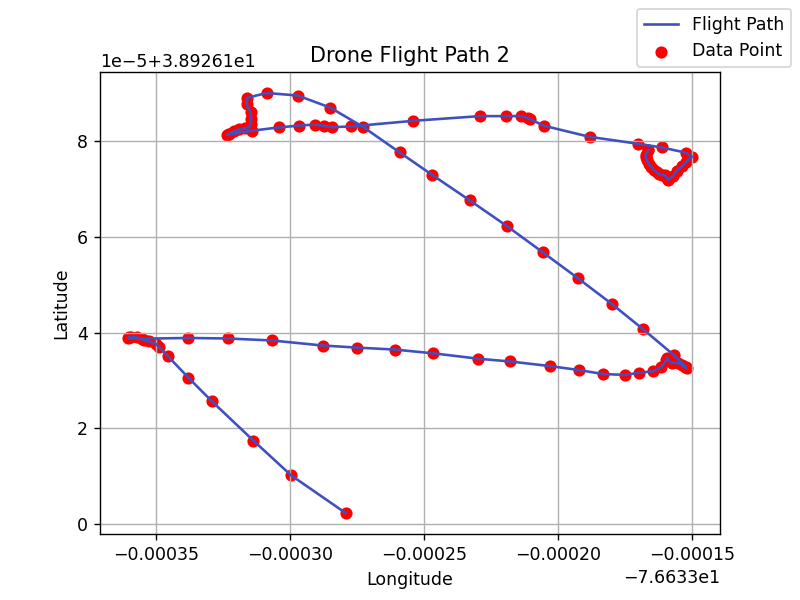

In [11]:
fig, ax = plt.subplots()
ax.scatter(maplist2['Longitude'], maplist2['Latitude'], c='red')
ax.plot(maplist2['Longitude'], maplist2['Latitude'], c='#3f50c0')
fig.legend(['Flight Path', 'Data Point'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Drone Flight Path 2")
plt.grid()


<IPython.core.display.Javascript object>


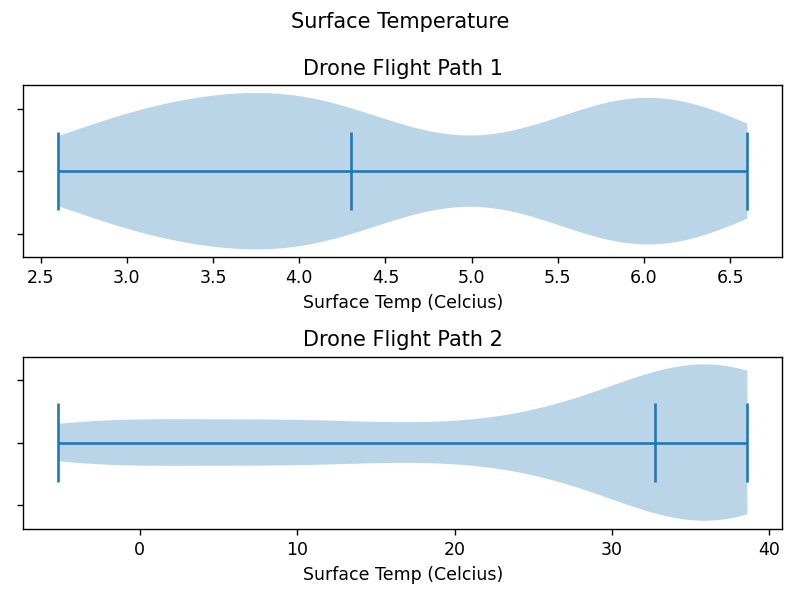

In [12]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.violinplot(maplist1['Surface Temp'], showmedians=True, vert=False)
ax2.violinplot(maplist2['Surface Temp'], showmedians=True, vert=False)
ax1.title.set_text('Drone Flight Path 1')
ax2.title.set_text('Drone Flight Path 2')
ax1.set_xlabel('Surface Temp (Celcius)')
ax1.set_yticklabels([])
ax2.set_xlabel('Surface Temp (Celcius)')
ax2.set_yticklabels([])
fig.suptitle('Surface Temperature')
fig.tight_layout(pad=1)

<IPython.core.display.Javascript object>


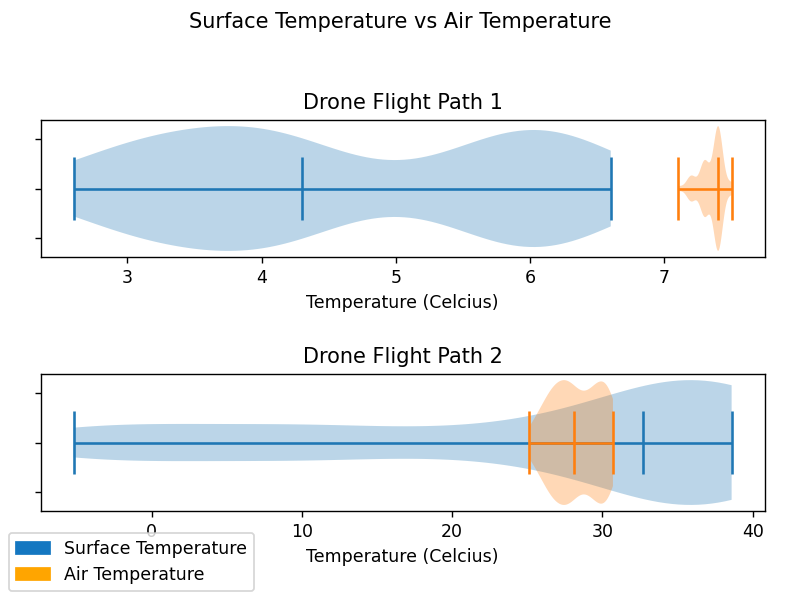

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.violinplot(maplist1['Surface Temp'], showmedians=True, vert=False)
ax1.violinplot(maplist1['Air Temp'], showmedians=True, vert=False)
ax2.violinplot(maplist2['Surface Temp'], showmedians=True, vert=False)
ax2.violinplot(maplist2['Air Temp'], showmedians=True, vert=False)
ax1.title.set_text('Drone Flight Path 1')
ax2.title.set_text('Drone Flight Path 2')
ax1.set_xlabel('Temperature (Celcius)')
ax1.set_yticklabels([])
ax2.set_xlabel('Temperature (Celcius)')
ax2.set_yticklabels([])
fig.suptitle('Surface Temperature vs Air Temperature')
fig.tight_layout(pad=2)
fig.legend((matplotlib.patches.Patch(color='#1477c1'), matplotlib.patches.Patch(color='orange')), ['Surface Temperature', 'Air Temperature'], loc ='lower left')

<IPython.core.display.Javascript object>


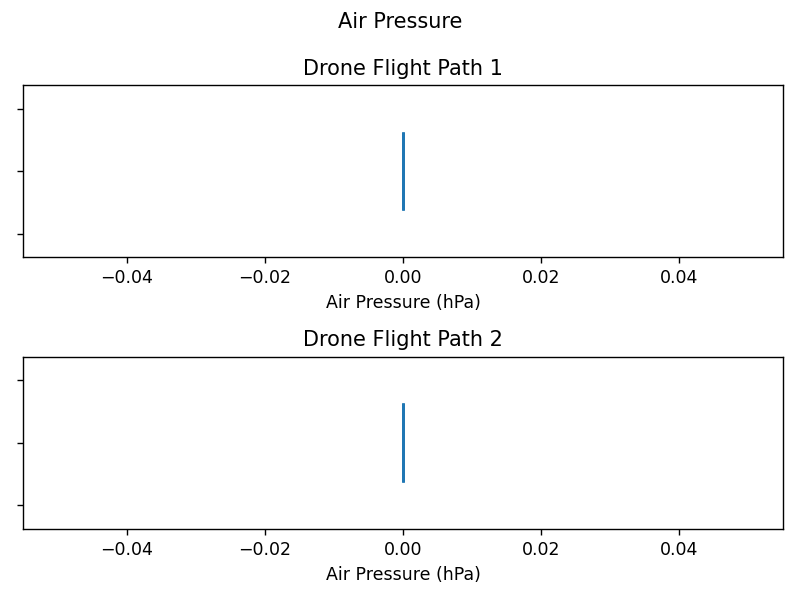

In [14]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.violinplot(maplist1['Air Pressure'], showmedians=True, vert=False)
ax2.violinplot(maplist2['Air Pressure'], showmedians=True, vert=False)
ax1.title.set_text('Drone Flight Path 1')
ax2.title.set_text('Drone Flight Path 2')
ax1.set_xlabel('Air Pressure (hPa)')
ax1.set_yticklabels([])
ax2.set_xlabel('Air Pressure (hPa)')
ax2.set_yticklabels([])
fig.suptitle('Air Pressure')
fig.tight_layout(pad=1)

2d plot, color plots, 3d plots, 3d with color for fun

Calculates and return piecewise gaussian function S represents a heaviside function following S(x,y,z) = y(1-H(x)) + zH(x), the three fit functions handel the x y z values for CIE standars 

In [15]:
def gaussian(alpha, lam, beta, gamma, delta):
    S = gamma if lam-beta < 0 else delta
    return alpha * math.exp(-0.5 * (((lam-beta)*S) ** 2))

def x_fit_31(wave):
    return (gaussian(0.362, wave, 442, 0.0624, 0.0375) + gaussian(1.056, wave, 599.8, 0.0264, 0.0323) + gaussian(-0.065, wave, 501.1, 0.0490, 0.0382))

def y_fit_31(wave):
    return (gaussian(0.821, wave, 568.8, 0.0213, 0.0247) + gaussian(0.286, wave, 530.9, 0.0613, 0.0322))

def z_fit_31(wave):
    return (gaussian(1.217, wave, 437, 0.0845, 0.0278) + gaussian(0.681, wave, 459, 0.0385, 0.0725))

Given spectral power data, return XYZ tristimulus values
Where X = sum(P(lam)*x(lam)*lam) and Y,Z also follow this equation

In [16]:
def spec_to_xyz(data, wl):
    X, Y, Z = 0, 0, 0
    wl_mult = [1.25, 1.1, 0.98, 0.98, 1, 1]

    for i in range(0,6):
        X += data[i] * x_fit_31(wl[i]) * wl[i] * wl_mult[i]
        Y += data[i] * y_fit_31(wl[i]) * wl[i] * wl_mult[i]
        Z += data[i] * z_fit_31(wl[i]) * wl[i] * wl_mult[i]

    sum = X + Y + Z
    if sum == 0:
        return 0,0,0
    return X/sum, Y/sum, Z/sum

convert CIE XYZ values to linear RGB uses sRGB M values, which is based on D50 white (references to source code in my presentation)

In [17]:
def xyz_to_rgb(XYZ):
    M = np.array([  [3.1338561, -1.6168667, -0.4906146],
                    [-0.9787684,  1.9161415,  0.0334540],
                    [0.0719453, -0.2289914,  1.4052427]])
    RGB = np.matmul(M, XYZ)
    return RGB

Correct RGB values for larger range
handles outside case exceptions

In [18]:
def gamma_correction(RGB):
    for x in range(0,3):
        if RGB[x] <= 0.0031308:
            RGB[x] *= 12.92
        else:
            RGB[x] = 1.055 * (RGB[x] ** (1/2.4)) - 0.055

    RGB = scale_brightness(RGB)
    return RGB

Handles extreme, out of RGB range cases

In [19]:
def out_of_range(RGB):
    col_min = min(RGB)
    if col_min < 0:
        for i in range(3):
            RGB[i] -= col_min

    if max(RGB) > 0:
        scale = 255 / max(RGB)
        if scale < 1:
            for i in range(3):
                RGB[i] *= scale

    return RGB

Scales brightness correctly

In [20]:
def scale_brightness(RGB):
    for x in range(3):
        RGB[x] *= 255

    out_of_range(RGB)
    return RGB

In [21]:
def rgb_to_hex(RGB):
    return "#{:02x}{:02x}{:02x}".format(int(RGB[0]), int(RGB[1]), int(RGB[2]))

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    return list(int(hex[i:i+2], 16) for i in (0, 2, 4))

In [22]:
def data_to_hex(data, wl):
    return rgb_to_hex(gamma_correction(xyz_to_rgb(spec_to_xyz(data, wl))))

Sets Visual Color and inserts it into maplist dataframe

In [23]:
vis_wl = [450, 500, 550, 570, 600, 650]
black = "#000000"
def set_vis(maplist):
    rbg_list = list()
    for i in range(0, len(maplist)):
        vis_pows = list()
        vis_pows.append(maplist['450 nm'][i])
        vis_pows.append(maplist['500 nm'][i])
        vis_pows.append(maplist['550 nm'][i])
        vis_pows.append(maplist['570 nm'][i])
        vis_pows.append(maplist['600 nm'][i])
        vis_pows.append(maplist['450 nm'][i])
        rgb = black
        rbg_list.append(data_to_hex(vis_pows, vis_wl))
    maplist.insert(27, 'Visual Color', rbg_list)

    


In [24]:
set_vis(maplist1)
set_vis(maplist2)

<IPython.core.display.Javascript object>


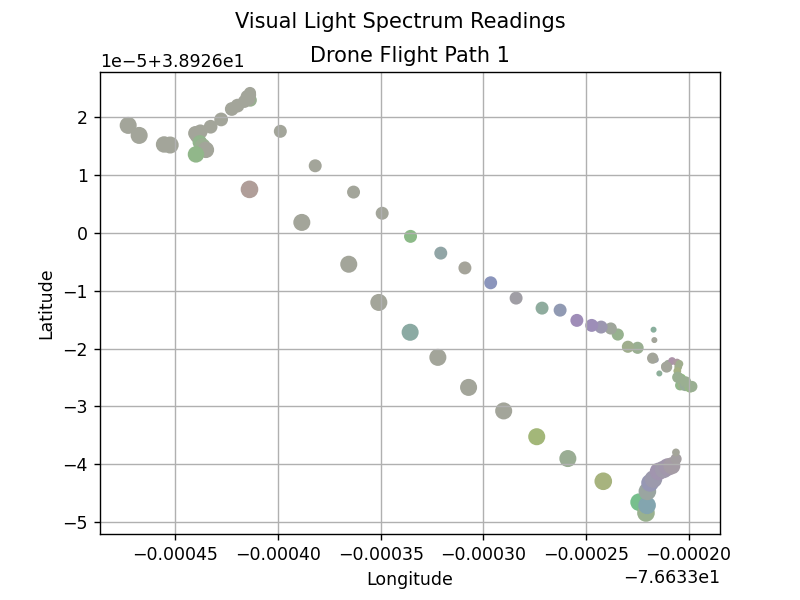

In [25]:
fig, ax = plt.subplots()
ax.scatter(maplist1['Longitude'], maplist1['Latitude'], c=maplist1['Visual Color'], s=maplist1['Confidence']*50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle('Visual Light Spectrum Readings')
plt.title("Drone Flight Path 1")
plt.grid()

<IPython.core.display.Javascript object>


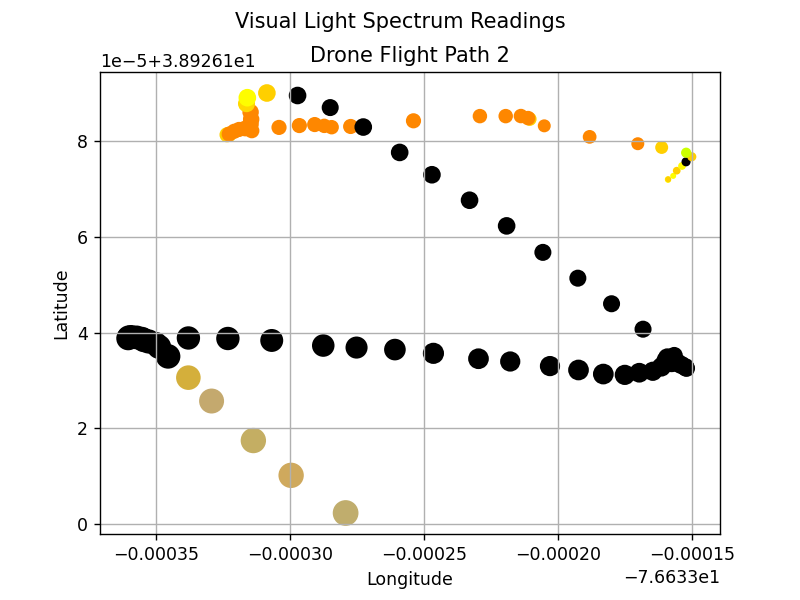

In [26]:
fig, ax = plt.subplots()
ax.scatter(maplist2['Longitude'], maplist2['Latitude'], c=maplist2['Visual Color'], s=maplist2['Confidence']*50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle('Visual Light Spectrum Readings')
plt.title("Drone Flight Path 2")
plt.grid()

gets the minimum and maximum temperature for the maplist

In [27]:
def get_min_temp(maplist):
    min_temp = float(maplist['Surface Temp'][0])
    for i in range(0, len(maplist)):
        if float(maplist['Surface Temp'][i]) < min_temp:
            min_temp = float(maplist['Surface Temp'][i])
    return min_temp


def get_max_temp(maplist):
    max_temp = float(maplist['Surface Temp'][0])
    for i in range(0, len(maplist)):
        if float(maplist['Surface Temp'][i]) > max_temp:
            max_temp = float(maplist['Surface Temp'][i])
    return max_temp

algorithm for producing false color maps

In [28]:
def false_color(value, min_val, max_val):
    d_blue = np.array([0, 0, 128])    # 0
    cyan = np.array([0, 255, 255])    # 0.25
    yellow = np.array([255, 255, 0])  # 0.5
    orange = np.array([255, 128, 0])  # 0.75
    red = np.array([255, 0, 0])       # 1

    color = []
    # convert temp to a percentage scale of 0 to 100
    p = (value - min_val)/(max_val - min_val)

    if p < 0.25:
        color = (1 - p / 0.25) * d_blue + (p / 0.25) * cyan
    elif p < 0.5:
        p = p - 0.25
        color = (1 - p / 0.25) * cyan + (p / 0.25) * yellow
    elif p < 0.75:
        p = p - 0.5
        color = (1 - p / 0.25) * yellow + (p / 0.25) * orange
    else:
        p = p - 0.75
        color = (1 - p / 0.25) * orange + (p / 0.25) * red
    return rgb_to_hex(color)


Adds temperature color to maplist dataframe

In [29]:
def set_temp(maplist):
    min_temp = get_min_temp(maplist)
    max_temp = get_max_temp(maplist) #max and min the sensor can see
    temp_list = list()
    
    for i in range(0, len(maplist)):
        temp_list.append(false_color(maplist['Surface Temp'][i], min_temp, max_temp))
    maplist.insert(28, 'Temperature Color', temp_list)

set_temp(maplist1)
set_temp(maplist2)

<IPython.core.display.Javascript object>


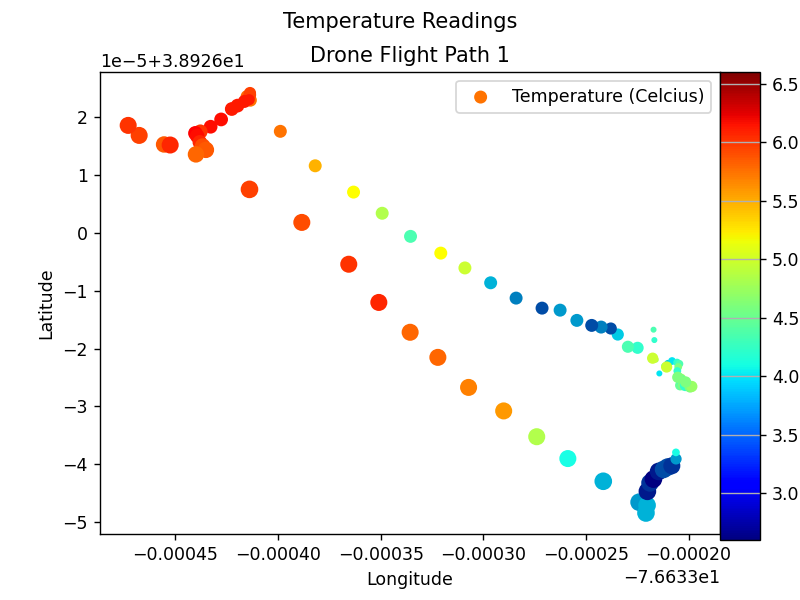

In [42]:
fig, ax = plt.subplots()
ax.scatter(maplist1['Longitude'], maplist1['Latitude'], c=maplist1['Temperature Color'], s=maplist1['Confidence']*50, cmap='jet')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Drone Flight Path 1')
plt.suptitle("Temperature Readings")
plt.legend(['Temperature (Celcius)'])
ax2  = fig.add_axes([0.90,0.10,0.05,0.78])
norm = matplotlib.colors.Normalize(vmin=get_min_temp(maplist1),vmax=get_max_temp(maplist1))
cb1  = matplotlib.colorbar.ColorbarBase(ax2,cmap=matplotlib.cm.jet,norm=norm,orientation='vertical', label='Temperature (Celcius)')
plt.grid()

<IPython.core.display.Javascript object>


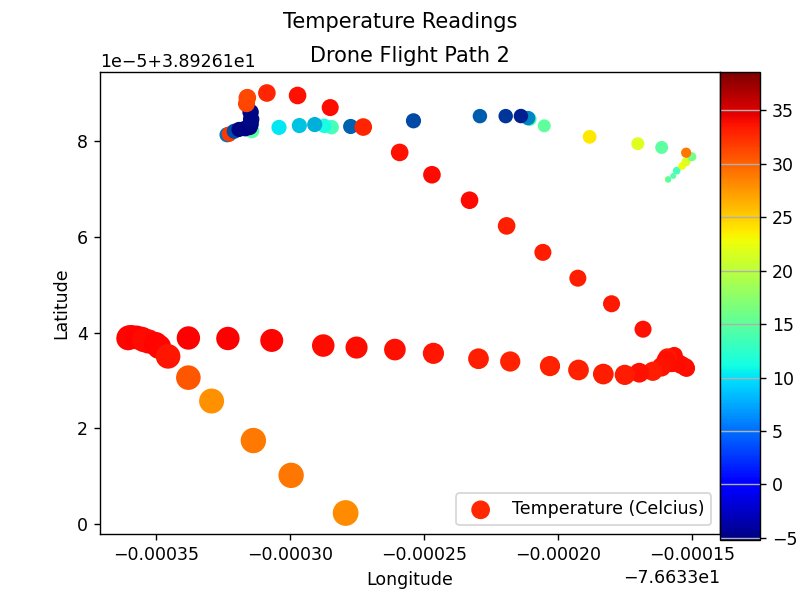

In [44]:
fig, ax = plt.subplots()
ax.scatter(maplist2['Longitude'], maplist2['Latitude'], c=maplist2['Temperature Color'], s=maplist2['Confidence']*50, cmap='jet')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend(['Temperature (Celcius)'], loc='lower right')
plt.title('Drone Flight Path 2')
plt.suptitle("Temperature Readings")
ax2  = fig.add_axes([0.90,0.10,0.05,0.78])
norm = matplotlib.colors.Normalize(vmin=get_min_temp(maplist2),vmax=get_max_temp(maplist2))
cb1  = matplotlib.colorbar.ColorbarBase(ax2,cmap=matplotlib.cm.jet,norm=norm,orientation='vertical', label='Temperature (Celcius)')
plt.grid()

3D visualization

<IPython.core.display.Javascript object>


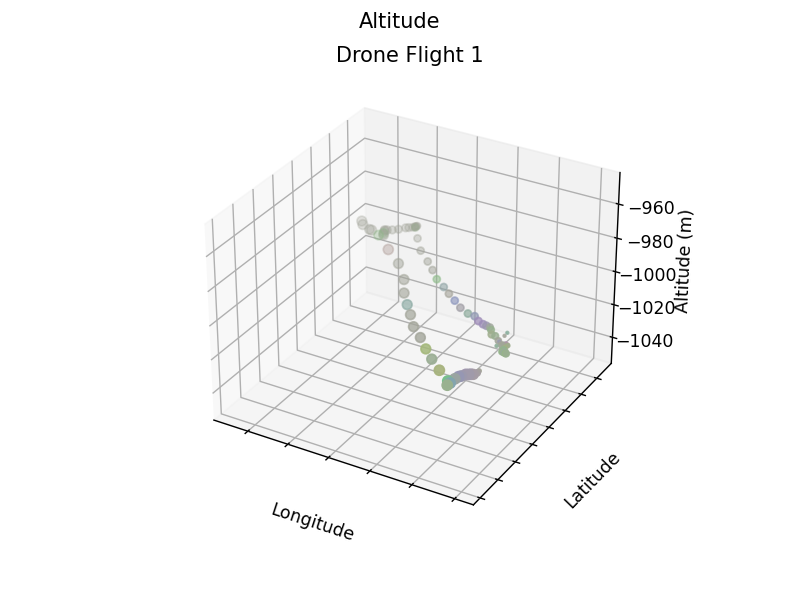

Text(0.5, 0.98, 'Altitude')

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist1['Longitude'], maplist1['Latitude'], maplist1['Altitude'], s=maplist1['Confidence']*20, c=maplist1['Visual Color'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Altitude (m)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 1')
plt.suptitle('Altitude')

<IPython.core.display.Javascript object>


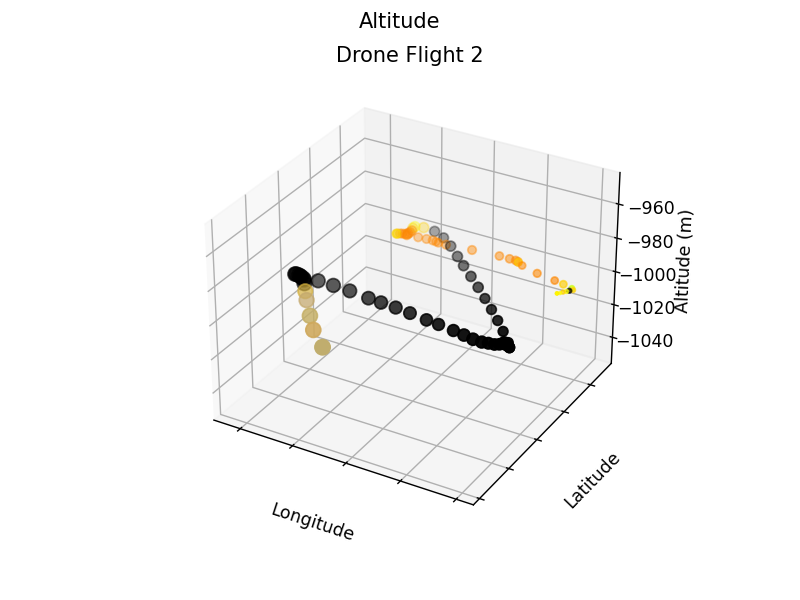

Text(0.5, 0.98, 'Altitude')

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist2['Longitude'], maplist2['Latitude'], maplist2['Altitude'],  s=maplist2['Confidence']*20, c=maplist2['Visual Color'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Altitude (m)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 2')
plt.suptitle('Altitude')

<IPython.core.display.Javascript object>


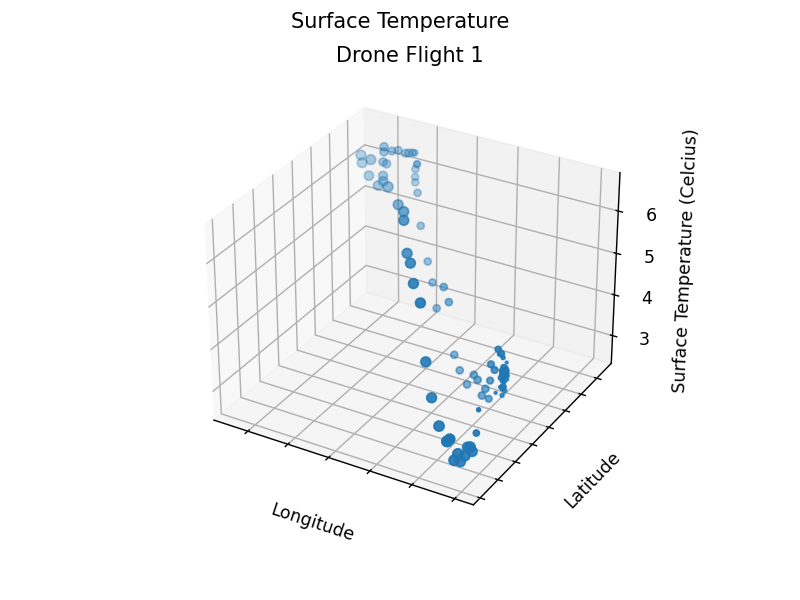

Text(0.5, 0.98, 'Surface Temperature')

In [34]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist1['Longitude'], maplist1['Latitude'], maplist1['Surface Temp'],  s=maplist1['Confidence']*20)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Surface Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 1')
plt.suptitle('Surface Temperature')

<IPython.core.display.Javascript object>


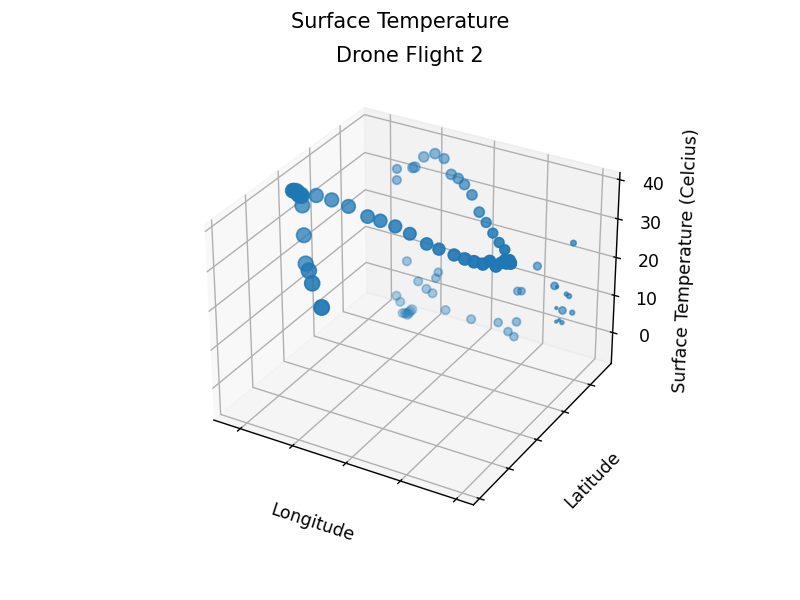

Text(0.5, 0.98, 'Surface Temperature')

In [35]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist2['Longitude'], maplist2['Latitude'], maplist2['Surface Temp'],  s=maplist2['Confidence']*20)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Surface Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 2')
plt.suptitle('Surface Temperature')

<IPython.core.display.Javascript object>


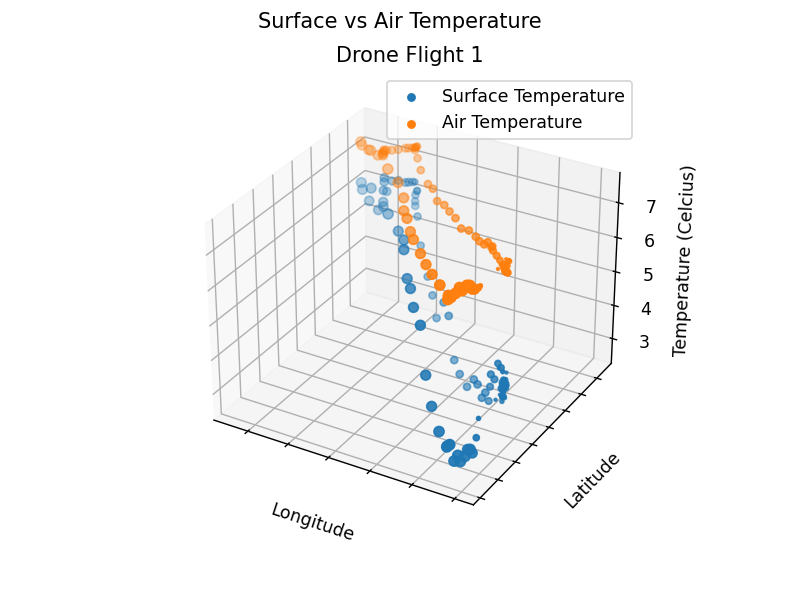

In [36]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist1['Longitude'], maplist1['Latitude'], maplist1['Surface Temp'],  s=maplist1['Confidence']*20)
ax.scatter3D(maplist1['Longitude'], maplist1['Latitude'], maplist1['Air Temp'],  s=maplist1['Confidence']*20)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 1')
plt.suptitle('Surface vs Air Temperature')
plt.legend(['Surface Temperature', 'Air Temperature'], loc='upper right')

<IPython.core.display.Javascript object>


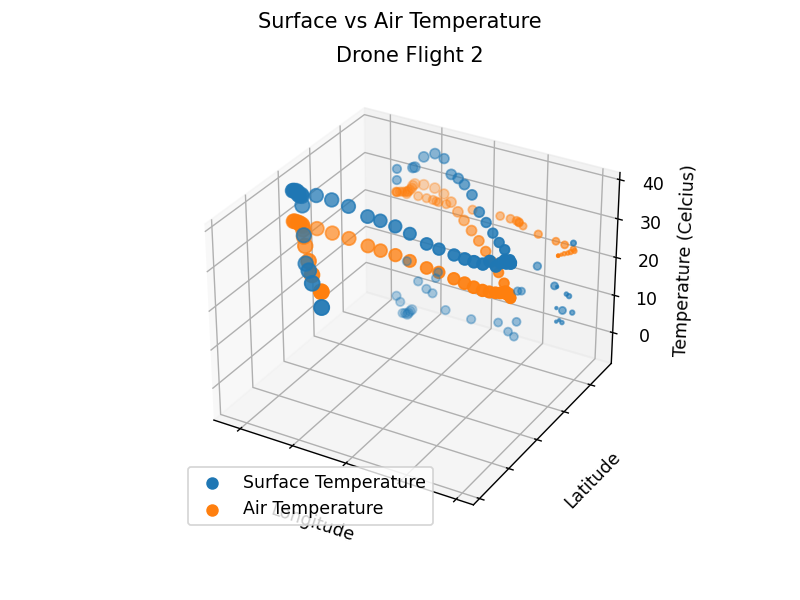

In [37]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist2['Longitude'], maplist2['Latitude'], maplist2['Surface Temp'],  s=maplist2['Confidence']*20)
ax.scatter3D(maplist2['Longitude'], maplist2['Latitude'], maplist2['Air Temp'],  s=maplist2['Confidence']*20)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 2')
plt.suptitle('Surface vs Air Temperature')
plt.legend(['Surface Temperature', 'Air Temperature'], loc='lower left')

<IPython.core.display.Javascript object>


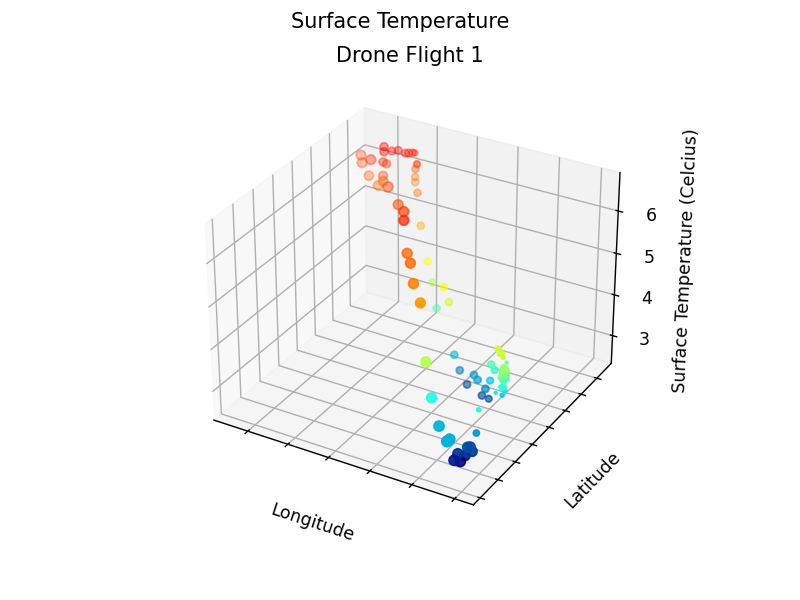

Text(0.5, 0.98, 'Surface Temperature')

In [38]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist1['Longitude'], maplist1['Latitude'], maplist1['Surface Temp'],  s=maplist1['Confidence']*20, c=maplist1['Temperature Color'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Surface Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 1')
plt.suptitle('Surface Temperature')

<IPython.core.display.Javascript object>


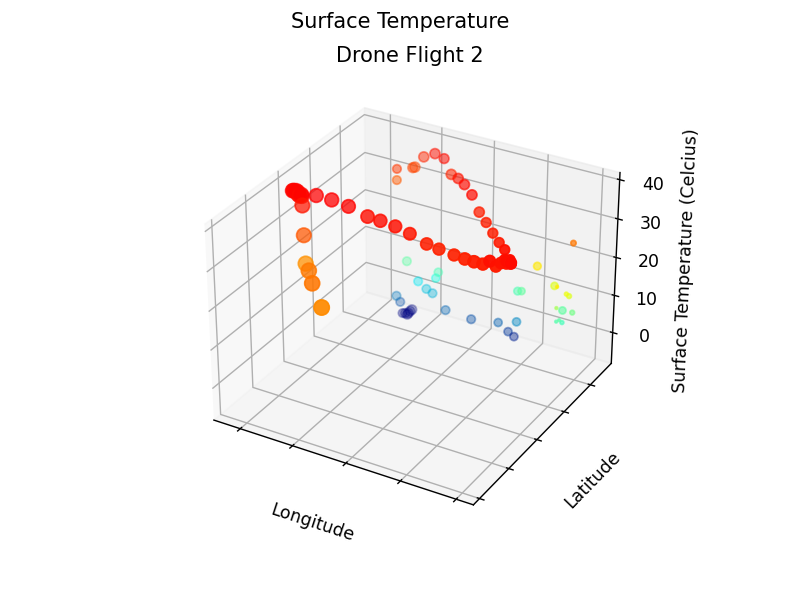

Text(0.5, 0.98, 'Surface Temperature')

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maplist2['Longitude'], maplist2['Latitude'], maplist2['Surface Temp'],  s=maplist2['Confidence']*20, c=maplist2['Temperature Color'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Surface Temperature (Celcius)')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Drone Flight 2')
plt.suptitle('Surface Temperature')

Note: I could not get geopandas to work in juptyer at all, otherwise I would've implemented what you suggested at the end of my presentation